In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='Eye_diseases',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1237 files belonging to 6 classes.


In [3]:
class_names =dataset.class_names
class_names

['Bulging_Eyes',
 'Cataracts',
 'Crossed_Eyes',
 'Glaucoma',
 'Normal_Eyes',
 'Uveitis']

In [4]:
len(dataset)

39

In [4]:
import numpy as np

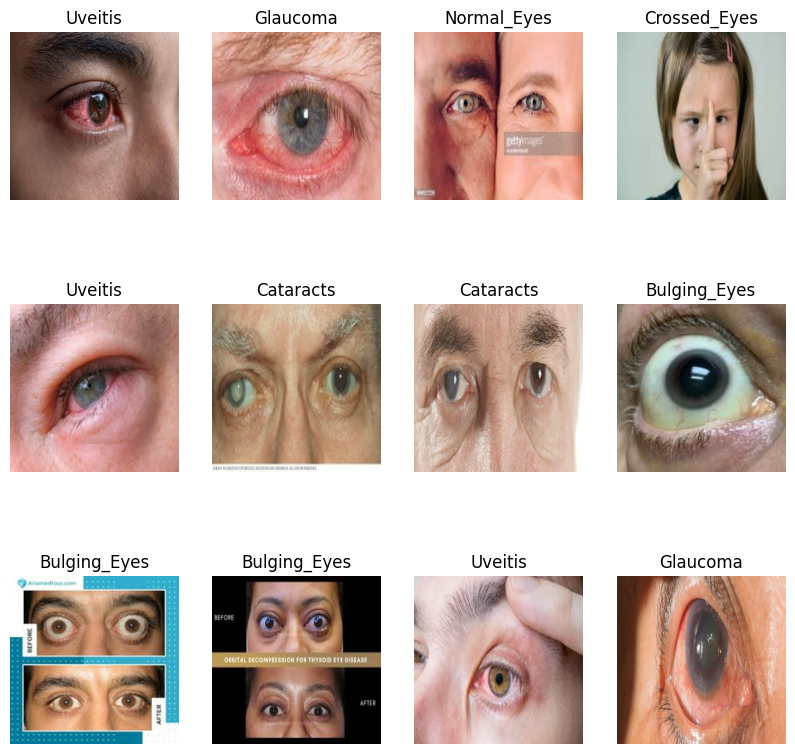

In [6]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [8]:
def get_datset_partition_tf(ds , train_split = 0.8 , val_split = 0.1 , test_split = 0.1 , shuffle=True , shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size , seed=12)
    
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [9]:
train_ds , val_ds, test_ds = get_datset_partition_tf(dataset)

In [9]:
len(train_ds)

31

In [10]:
len(val_ds)

3

In [11]:
len(test_ds)

5

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_and_reshape = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
layers = tf.keras.layers
models = tf.keras.models

In [16]:
input_shapes = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 6

model = models.Sequential([
    layers.Conv2D(32 , (3,3) , activation='relu' , input_shape= input_shapes),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (2,2) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128 , (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128 , (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)      

In [18]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
EPOCH = 80
history = model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds,
)

Epoch 1/80
31/31 [==============================] - 150s 5s/step - loss: 3.5457 - accuracy: 0.2470 - val_loss: 1.6615 - val_accuracy: 0.3854
Epoch 2/80
31/31 [==============================] - 114s 4s/step - loss: 1.6547 - accuracy: 0.3175 - val_loss: 1.5663 - val_accuracy: 0.4375
Epoch 3/80
31/31 [==============================] - 100s 3s/step - loss: 1.5335 - accuracy: 0.3730 - val_loss: 1.4102 - val_accuracy: 0.4271
Epoch 4/80
31/31 [==============================] - 114s 4s/step - loss: 1.4138 - accuracy: 0.4476 - val_loss: 1.2898 - val_accuracy: 0.5312
Epoch 5/80
31/31 [==============================] - 131s 4s/step - loss: 1.2486 - accuracy: 0.5222 - val_loss: 1.1542 - val_accuracy: 0.5625
Epoch 6/80
31/31 [==============================] - 117s 4s/step - loss: 1.0676 - accuracy: 0.5857 - val_loss: 1.0951 - val_accuracy: 0.6667
Epoch 7/80
31/31 [==============================] - 115s 4s/step - loss: 0.9254 - accuracy: 0.6472 - val_loss: 0.9859 - val_accuracy: 0.6354
Epoch 8/80
31

In [5]:
model.save('Eyes.h5')

NameError: name 'model' is not defined

In [21]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 9s 813ms/step - loss: 0.4839 - accuracy: 0.8813


In [6]:
model = tf.keras.models.load_model('Eyes.h5')

In [20]:
from PIL import Image

1/1 [==============================] - 0s 171ms/step
[[4.9782212e-10 9.9999797e-01 1.5386924e-11 1.1203621e-06 1.5398890e-09
  9.7732584e-07]]
Cataracts
0.999998


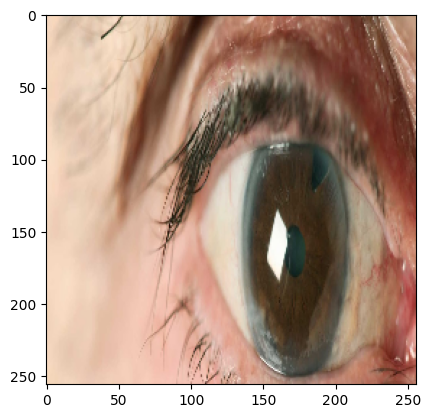

In [27]:
image_path = 'C:/Users/user/Downloads/1.jpg'
image = tf.keras.preprocessing.image.load_img(image_path , target_size=(IMAGE_SIZE,IMAGE_SIZE))
image_arr = tf.keras.preprocessing.image.img_to_array(image)
x_train = np.expand_dims(image_arr , axis=0)
prediction = model.predict(x_train)
confidence = np.max(prediction)
print(prediction)
print(class_names[np.argmax(prediction)])
print(confidence)
plt.imshow(image)
plt.show()